In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pyarrow.parquet as pq
import sys
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import math
from IPython.display import clear_output
import logging
from pathlib import Path

import matplotlib.pyplot as plt
sys.path.append('../../../')

from configs.data_configs.rosbank import data_configs
from configs.model_configs.gen.rosbank import model_configs
from src.models.mTAND.model import MegaNet, MegaNetCE, MegaNetSupervised
from src.data_load.dataloader import create_data_loaders, create_test_loader
from src.trainers.trainer_mTAND import MtandTrainer

from src.create_embeddings import create_embeddings

from src.data_load import split_strategy
from src.data_load.data_utils import prepare_data
from src.data_load.splitting_dataset import (
    ConvertingTrxDataset,
    TargetDataset,
    DropoutTrxDataset,
    SplittingDataset,
    TargetEnumeratorDataset,
)
from src.data_load.dataloader import collate_splitted_rows, padded_collate, PaddedBatch
from torch.utils.data import DataLoader

from sklearn.linear_model import LogisticRegression

from src.models.preprocessors import FeatureProcessor

from torch.autograd import Variable

from src.models.gen_models import SeqGen

from sklearn.metrics import roc_auc_score

/home/event_seq/experiments/rosbank/notebooks/../../../src/trainers/base_trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
conf = data_configs()
model_conf = model_configs()

In [3]:
df = pd.read_parquet(conf.test_path)
df.head()

,cl_id,amount,event_time,mcc,channel_type,currency,trx_category,trx_count,target_target_flag,target_target_sum
0,10096,"[5.209486152841421, 11.289794413577894, 6.5381...","[17310.0, 17310.44556712963, 17312.0, 17312.0,...","[3, 2, 1, 8, 16, 32, 1, 5, 16, 1, 3, 3, 8, 3, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",186,0,0.0
1,1718,"[10.463131911491967, 9.200391041122515, 8.4765...","[17113.0, 17113.0, 17113.065914351853, 17117.0...","[2, 80, 2, 2, 1, 6, 6, 1, 2, 100, 2, 2, 2, 1, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[6, 1, 3, 6, 1, 1, 1, 1, 3, 1, 3, 3, 6, 1, 1, ...",42,1,95755.67
2,3260,"[5.995207533386816, 4.0943445622221, 6.0776422...","[17444.0, 17445.0, 17445.0, 17445.0, 17445.617...","[1, 1, 4, 1, 2, 1, 47, 1, 3, 17, 1, 1, 1, 8, 8...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",169,1,36862.75
3,3529,"[7.941626359306345, 7.692113339595466, 6.04263...","[17214.0, 17214.0, 17214.0, 17214.0, 17216.0, ...","[1, 1, 86, 26, 23, 1, 1, 7, 3, 11, 1, 1, 4, 1,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",69,1,9553.28
4,5335,"[8.006700845440367, 7.484930283289661, 7.10414...","[17203.0, 17203.0, 17203.0, 17203.668090277777...","[25, 16, 31, 2, 2, 2, 52, 3, 3, 17, 17, 1, 28,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",155,0,0.0


In [9]:
target = df['target_target_flag'].values.astype(int)

In [12]:
pred = np.random.randint(low=0, high=2, size=500)

In [13]:
roc_auc_score(target, pred)

0.4590031491648942

In [3]:
layer = nn.TransformerEncoderLayer(d_model=3, nhead=1, batch_first=True)
encoder = nn.TransformerEncoder(layer, num_layers=1)

In [3]:
x = torch.rand(2,3,1)

In [6]:
x.tolist()[0]

[[0.8312996029853821], [0.7697743773460388], [0.3033192753791809]]

In [7]:
g = pd.read_parquet('/home/event_seq/experiments/rosbank/gen/ckpt/generated_data/test_2023-10-23_14:55:39')

In [8]:
g.head()

,event_time,trx_count,target_target_flag,channel_type,currency,mcc,trx_category,amount,cl_id
0,"[17318.897932486696, 17321.000002735003, 17321...",161,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5.288522720336914, 5.2897491455078125, 5.2891...",0
1,"[17304.999992843565, 17304.999992843565, 17305...",37,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5.289129257202148, 5.289804935455322, 5.28974...",1
2,"[17365.99999920236, 17365.99999920236, 17365.9...",48,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5.286594390869141, 5.28878116607666, 5.288440...",2
3,"[17106.000000284897, 17106.999999891745, 17106...",111,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5.28599739074707, 5.288999080657959, 5.288941...",3
4,"[17170.000003441506, 17170.000003441506, 17170...",199,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5.28809928894043, 5.289484024047852, 5.289320...",4


In [12]:
class FeatureMixer(nn.Module):
    def __init__(self, num_features, feature_dim, num_layers):
        super().__init__()
        self.num_features = num_features
        self.feature_dim = feature_dim
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_dim, nhead=1, batch_first=True
        )
        self.encoder_norm = nn.LayerNorm(feature_dim)
        self.encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers, norm=self.encoder_norm
        )

    def forward(self, x):
        bs, seq_len, d = x.size()

        x_resized = x.view(bs * seq_len, self.num_features, self.feature_dim)
        x_resized.requires_grad_(True)
        out = self.encoder(x_resized).view(
            bs, seq_len, self.num_features * self.feature_dim
        )
        out.requires_grad_(True)
        return out

In [13]:
x = torch.rand(8, 9, 6)
fm = FeatureMixer(2, 3, 1)

In [14]:
out = fm(x)

In [15]:
out.sum().backward()

In [16]:
for param in fm.named_parameters():
    print(param[0], param[1].grad)

encoder_norm.weight tensor([ -7.4740, -35.4037,  42.8777])
encoder_norm.bias tensor([144., 144., 144.])
encoder.layers.0.self_attn.in_proj_weight tensor([[-2.7600e-09, -1.9538e-09, -2.0469e-09],
        [-1.1444e-09, -6.6039e-10, -8.3439e-10],
        [-1.6732e-09, -1.3196e-09, -1.2175e-09],
        [ 1.7628e-09, -1.0601e-09,  1.9421e-09],
        [ 3.5808e-10,  2.5547e-10,  1.5019e-10],
        [-5.1543e-10, -3.8865e-10, -2.5830e-10],
        [ 3.2546e-08,  2.4552e-08,  3.0092e-08],
        [ 6.4636e-08,  2.4516e-08,  7.6349e-08],
        [ 2.2333e-07,  1.6401e-07,  1.7907e-07]])
encoder.layers.0.self_attn.in_proj_bias tensor([-4.4784e-09, -1.5944e-09, -2.8767e-09, -2.6368e-16, -8.9338e-17,
         1.0582e-16,  6.1356e-08,  1.1051e-07,  3.8556e-07])
encoder.layers.0.self_attn.out_proj.weight tensor([[-1.6876e-07, -1.3261e-07,  1.6365e-07],
        [ 2.8565e-07,  2.1760e-07, -2.0757e-07],
        [-2.4238e-07, -1.5141e-07,  1.1435e-07]])
encoder.layers.0.self_attn.out_proj.bias tensor

In [107]:
before = torch.rand(2, 3, 6)
bf = before.view(2*3, 3, 2)


In [108]:
before == bf.view(2,3,6)

tensor([[[True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True]],

        [[True, True, True, True, True, True],
         [True, True, True, True, True, True],
         [True, True, True, True, True, True]]])

In [96]:
bf

tensor([[[0.7294, 0.9365],
         [0.2278, 0.6704],
         [0.6854, 0.8161]],

        [[0.0319, 0.6790],
         [0.0531, 0.8009],
         [0.7376, 0.1606]],

        [[0.2345, 0.9561],
         [0.7418, 0.7731],
         [0.5280, 0.9977]],

        [[0.5158, 0.1210],
         [0.6602, 0.7736],
         [0.1866, 0.2895]],

        [[0.9004, 0.2434],
         [0.3048, 0.8673],
         [0.3183, 0.8579]],

        [[0.5168, 0.0103],
         [0.2954, 0.7092],
         [0.7974, 0.9518]]])

In [90]:
print(bf[1])
bf[1] += 1
print(bf[1])

tensor([[1.4193, 1.3570],
        [1.8115, 1.4397],
        [1.8518, 1.2003]])
tensor([[2.4193, 2.3570],
        [2.8115, 2.4397],
        [2.8518, 2.2003]])


In [92]:
after = bf.view(2, 3, 6)

In [93]:
after[1] == before

tensor([[[False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False]],

        [[ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True]]])

In [4]:
gen = pd.read_parquet('/home/event_seq/experiments/rosbank/gen/ckpt/generated_data/test_2023-10-06_15:07:22')

In [133]:
gen['code'] = gen['event_time'].apply(sum)

In [134]:
df['code'] = df['event_time'].apply(lambda x: x[1:].sum())

In [135]:
mapping = {}
for i in range(len(gen)):
    if np.isclose(gen['code'][i], df['code'], atol=1e-5).sum() == 1:
        mask = np.isclose(gen['code'][i], df['code'], atol=1e-5)
        #print(gen['target_target_flag'][i], df['target_target_flag'][mask].values[0])
        if (gen['target_target_flag'][i] == int(df['target_target_flag'][mask].values[0])):
            if abs(gen['code'][i] - df['code'][mask].values[0]) < 1e-5:
                mapping[i] = df['target_target_flag'][mask].index[0]

In [ ]:
for gen_id, df_id in mapping.items():
    (gen['code'][gen_id] - df.loc[df_id]['code'])
    print(np.abs(gen.loc[gen_id]['amount'] - df.loc[df_id]['amount'][1:]).mean())


In [137]:
gen.loc[gen_id]['channel_type'], df.loc[df_id]['channel_type']

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32))

In [150]:
gen.loc[gen_id]['mcc'], df.loc[df_id]['mcc']

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([ 9,  1, 36, 11, 16, 15, 41,  1,  1, 14,  3,  7,  7, 16, 16,  1, 14,
         7, 14,  1, 13, 13, 13, 11, 11, 14, 11,  1,  1, 11,  5, 36,  1, 11,
        11,  1, 16,  7,  1,  1,  6, 14,  7,  1,  1, 11,  1,  1, 13,  1,  7,
        11,  7, 14,  1, 20,  1,  1, 14, 11,  1, 16, 16, 13, 14,  1,  1,  1,
        11,  1, 14,  1, 14,  1, 11,  8,  8,  1,  8, 13,  5,  2,  2],
       dtype=int32))

In [139]:
gen.loc[gen_id]['currency'], df.loc[df_id]['currency']

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32))

In [149]:
np.bincount(gen['mcc'][6])

array([ 0, 79, 58,  0, 36])

In [146]:
gen['mcc'][0]

array([1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 4, 1, 1, 1,
       2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1])

In [115]:
df['amount'].apply(lambda x: sum(x<0)).sum()

0

In [124]:
df['channel_type']

0           [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
2       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
3       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
4       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
                              ...                        
4495    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
4496    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
4497    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...
4498    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
4499    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: channel_type, Length: 4500, dtype: object

In [127]:
gen['channel_type'].apply(lambda x: sum(x == 1)).sum()

0

In [5]:
train_loader, valid_loader = create_data_loaders(conf)


1698it [00:00, 16972.85it/s]

4500it [00:00, 19468.85it/s]


In [6]:
for batch in train_loader:
    break

In [17]:
batch[0].payload['event_time']

tensor([[ 0.1510,  0.1514,  0.1731,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.1750,  0.1764,  0.1779,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.1805,  0.1823,  0.1823,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [ 0.4954,  0.5009,  0.5046,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.4825,  0.4862,  0.4881,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.5323,  0.5323,  0.5323,  ..., -1.0000, -1.0000, -1.0000]],
       dtype=torch.float64)

In [7]:
(df['cl_id'] == 0).sum()

0

In [8]:
df_dic = {'mcc': [[1, 2], [3,4]], 'curr': [[0,1], [0,0]]}
pd.DataFrame.from_dict(df_dic)

,mcc,curr
0,"[1, 2]","[0, 1]"
1,"[3, 4]","[0, 0]"


In [7]:
df_dic = {}
for feature in conf.features.embeddings.keys():
    df_dic[feature] = []

for feature in conf.features.numeric_values.keys():
    df_dic[feature] = []

for key, val in batch[0].payload.items():
    df_dic[key].extend(val.tolist())

KeyError: 'event_time'

In [ ]:
pd.DataFrame.from_dict(df_dic)

,channel_type,currency,mcc,trx_category,amount
0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[7, 3, 2, 2, 9, 3, 2, 3, 99, 2, 7, 8, 14, 2, 9...","[2, 4, 2, 2, 2, 4, 2, 5, 2, 2, 2, 2, 8, 2, 2, ...","[6.8416154764775925, 6.2166061010848646, 6.590..."
1,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[8, 3, 3, 3, 3, 2, 2, 68, 95, 2, 2, 38, 37, 74...","[2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[7.06296254328452, 7.313886831633462, 10.77897..."
2,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[96, 12, 3, 8, 8, 8, 2, 16, 16, 12, 48, 92, 21...","[2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[6.730862957183067, 7.02197642307216, 9.210440..."
3,"[3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[59, 2, 30, 59, 59, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11.225256725762893, 5.863631175598097, 11.225..."
4,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[3, 3, 16, 37, 12, 3, 3, 4, 4, 4, 4, 5, 13, 5,...","[3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, ...","[9.852246888342531, 6.90875477931522, 9.888932..."
...,...,...,...,...,...
123,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, ...","[32, 32, 14, 49, 82, 49, 46, 46, 29, 56, 49, 4...","[2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[5.303304908059076, 6.311734809152915, 9.35452..."
124,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 3, 47, 85, 6, 6, 2, 2, 2, 2, 39, 7, 2, 2, ...","[2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[7.071573364211532, 11.156264806643742, 9.8632..."
125,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[6, 3, 3, 3, 2, 2, 8, 4, 3, 3, 9, 9, 9, 3, 4, ...","[2, 4, 5, 9, 2, 2, 2, 2, 4, 4, 2, 2, 2, 4, 2, ...","[6.566672429803241, 11.938199736300925, 12.013..."
126,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[3, 3, 3, 3, 3, 3, 3, 3, 66, 3, 3, 3, 3, 3, 3,...","[4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, ...","[10.596659732783579, 10.596659732783579, 10.59..."


In [7]:
net = SeqGen(model_conf=model_conf, data_conf=conf)

In [8]:
gts = []
outs = []
for batch in tqdm(train_loader):
    out = net(batch[0])
    outs.append(out)
    gts.append(batch[1])
    break

  0%|          | 0/62 [00:02<?, ?it/s]


In [9]:
def out_to_padded_batch(out, conf):
    order = {}

    k = 0
    for key in outs[0]['input_batch'].payload.keys():
        if key in conf.features.numeric_values.keys():
            order[k] = key
            k += 1

    num_numeric = len(conf.features.numeric_values.keys())

    payload = {}
    payload['event_time'] = out['time_steps'][:,1:]
    length = (out['time_steps'][:,1:] != -1).sum(dim=1)
    mask = (out['time_steps'][:,1:] != -1)
    for key, val in out['emb_dist'].items():
        payload[key] = val.cpu().argmax(dim=-1).detach()
        payload[key][~mask] = 0


    if model_conf.use_deltas:
        pred_delta = out['pred'][:, :, -1].squeeze(-1)
        pred = out['pred'][:, :, :-1]

    numeric_pred = pred[:,:,-num_numeric:]
    for i in range(num_numeric):
        cur_key = order[i]
        cur_val = numeric_pred[:,:,i].cpu().detach()
        payload[cur_key] = cur_val
        payload[cur_key][~mask] = 0

    return PaddedBatch(payload, length)


In [10]:
gen_batch = out_to_padded_batch(out, conf)

In [11]:
gen_batch, batch[0]

(<src.data_load.dataloader.PaddedBatch at 0x7f888a853910>,
 <src.data_load.dataloader.PaddedBatch at 0x7f8599aab1c0>)

In [12]:
gen_batch.payload['mcc'].size(), batch[0].payload['mcc'][:,:-1].size()

(torch.Size([64, 199]), torch.Size([64, 199]))

In [13]:
torch.cat([gen_batch.payload['mcc'], batch[0].payload['mcc'][:,:-1]], dim=0).size()

torch.Size([128, 199])

In [41]:
def mix_batches(gen_batch, true_batch):

    new_payload = {}
    for key in gen_batch.payload.keys():
        new_payload[key] = torch.cat([gen_batch.payload[key], true_batch.payload[key][:,:-1]], dim=0)
    new_lens = torch.cat([gen_batch.seq_lens, true_batch.seq_lens-1])

    new_batch = PaddedBatch(new_payload, new_lens)
    
    d_labels = torch.zeros(len(new_batch), dtype=torch.long)
    d_labels[:len(new_batch) // 2] = 1

    return new_batch, d_labels

In [42]:
b, l = mix_batches(gen_batch, batch[0])

In [48]:
l.unsqueeze(0).repeat(2, 1)[1]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
new_batch = PaddedBatch(new_payload, new_lens)


In [24]:
len(new_batch)

128

In [27]:
d_labels = torch.zeros(len(new_batch))
d_labels[:len(new_batch) // 2] = 1

In [37]:
d_labels[127]

tensor(0.)

In [11]:
mask = (out['time_steps'][:,1:] != -1)

In [18]:
val_pred = val.cpu().argmax(dim=-1)
val_pred[~mask] = 0

In [21]:
val_pred[1]

tensor([5, 5, 4, 4, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5, 4, 4,
        4, 4, 5, 5, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])

In [60]:
def output_to_df(outs, gts):
    order = {}

    k = 0
    for key in outs[0]['input_batch'].payload.keys():
        if key in conf.features.numeric_values.keys():
            order[k] = key
            k += 1

    df_dic = {'event_time': [], 'trx_count': [], conf.features.target_col: []}
    for feature in conf.features.embeddings.keys():
        df_dic[feature] = []

    for feature in conf.features.numeric_values.keys():
        df_dic[feature] = []

    for out, gt in zip(outs, gts):
        for key, val in out['emb_dist'].items():
            df_dic[key].extend(val.cpu().argmax(dim=-1).tolist())


        if model_conf.use_deltas:
            pred_delta = out['pred'][:, :, -1].squeeze(-1)
            pred = out['pred'][:, :, :-1]

        num_numeric = len(conf.features.numeric_values.keys())
        numeric_pred = pred[:,:,-num_numeric:]
        for i in range(num_numeric):
            cur_key = order[i]
            cur_val = numeric_pred[:,:,i].cpu().tolist()
            df_dic[cur_key].extend(cur_val)

        df_dic['event_time'].extend(out['time_steps'][:,1:].tolist())
        df_dic['trx_count'].extend((out['time_steps'][:,1:] != -1).sum(dim=1).tolist())
        df_dic['target_target_flag'].extend(gt[1].cpu().tolist())


    generated_df = pd.DataFrame.from_dict(df_dic)
    generated_df['event_time'] = generated_df['event_time'].apply(lambda x: (np.array(x) * (conf.max_time - conf.min_time)) + conf.min_time)
    def truncate_lists(row):
        value = row["trx_count"]
        for col in row.index:
            if isinstance(row[col], (np.ndarray, list)):
                row[col] = row[col][:value]
        return row

    generated_df = generated_df.apply(func=truncate_lists, axis=1)

    generated_df[conf.col_id] = np.arange(len(generated_df))
    return generated_df

In [61]:
gen_df = output_to_df(outs, gts)

In [62]:
gen_df.to_parquet('test_df.parquet')

In [63]:
conf.train_supervised_path = Path('/home/event_seq/experiments/rosbank/notebooks/test_df.parquet')

In [64]:
train_loader, valid_loader = create_data_loaders(conf, supervised=True)

0it [00:00, ?it/s]

3918it [00:00, 21584.40it/s]


In [65]:
for batch in train_loader:
    break

In [69]:
batch[0].payload

{'channel_type': tensor([[3, 3, 3,  ..., 0, 0, 0],
         [3, 3, 3,  ..., 0, 0, 0],
         [3, 3, 3,  ..., 0, 0, 0],
         ...,
         [3, 3, 3,  ..., 0, 0, 0],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]]),
 'currency': tensor([[3, 3, 3,  ..., 0, 0, 0],
         [3, 3, 3,  ..., 0, 0, 0],
         [3, 3, 3,  ..., 0, 0, 0],
         ...,
         [3, 3, 3,  ..., 0, 0, 0],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]]),
 'mcc': tensor([[2, 2, 2,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0],
         ...,
         [2, 2, 2,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]]),
 'trx_category': tensor([[9, 9, 9,  ..., 0, 0, 0],
         [9, 9, 9,  ..., 0, 0, 0],
         [9, 9, 9,  ..., 0, 0, 0],
         ...,
         [9, 9, 9,  ..., 0, 0, 0],
         [9, 9, 9,  ..., 9, 9, 9],
         [9, 9, 9,  ..., 9, 9, 9]]),
 'amount': tensor([[0.1943, 0.1114, 0.1366,  

In [40]:
torch.cumsum(pred_delta[0], dim=0)

tensor([ 0.2167,  0.4243,  0.6401,  0.8549,  1.0706,  1.2812,  1.4994,  1.7086,
         1.9264,  2.1430,  2.3536,  2.5688,  2.7799,  2.9977,  3.2112,  3.4298,
         3.6440,  3.8559,  4.0742,  4.2852,  4.5045,  4.7123,  4.9371,  5.1520,
         5.3646,  5.5771,  5.7939,  6.0026,  6.2179,  6.4309,  6.6444,  6.8651,
         7.0795,  7.2949,  7.5053,  7.7209,  7.9334,  8.1450,  8.3612,  8.5773,
         8.7870,  9.0079,  9.2151,  9.4337,  9.6470,  9.8614, 10.0750, 10.2931,
        10.5078, 10.7236, 10.9383, 11.1544, 11.3685, 11.5835, 11.7935, 12.0073,
        12.2203, 12.4350, 12.6478, 12.8651, 13.0787, 13.2881, 13.5084, 13.7253,
        13.9408, 14.1587, 14.3687, 14.5847, 14.8013, 15.0105, 15.2255, 15.4438,
        15.6534, 15.8676, 16.0804, 16.2990, 16.5115, 16.7281, 16.9444, 17.1618,
        17.3783, 17.5956, 17.8040, 18.0197, 18.2352, 18.4484, 18.6684, 18.8786,
        19.0920, 19.3045, 19.5223, 19.7397, 19.9560, 20.1680, 20.3867, 20.6042,
        20.8174, 21.0353, 21.2498, 21.45

In [9]:
loss = net.loss(out, batch[1])

In [10]:
loss

{'mse_loss': tensor(1.0479, grad_fn=<DivBackward0>),
 'total_CE_loss': tensor(9.9209, grad_fn=<SumBackward0>),
 'delta_loss': tensor(0.0690, grad_fn=<DivBackward0>),
 'channel_type': tensor(1.4719, grad_fn=<NllLoss2DBackward0>),
 'currency': tensor(1.3469, grad_fn=<NllLoss2DBackward0>),
 'mcc': tensor(4.6315, grad_fn=<NllLoss2DBackward0>),
 'trx_category': tensor(2.4707, grad_fn=<NllLoss2DBackward0>),
 'total_loss': tensor(17.8654, grad_fn=<AddBackward0>)}

In [19]:
for batch in train_loader:
    break

fp = FeatureProcessor(model_conf=model_conf, data_conf=conf)
x, time_steps = fp(batch[0])

In [7]:
gt_delta = time_steps.diff(1)

In [15]:
gt_delta = time_steps.diff(1)
delta_feature =torch.cat([gt_delta, torch.zeros(128, 1)], dim=1)
torch.cat([x, delta_feature.unsqueeze(-1)], dim=-1)

In [17]:
x.size(), delta_feature.size()

(torch.Size([128, 200, 33]), torch.Size([128, 200]))

In [18]:
torch.cat([x, delta_feature.unsqueeze(-1)], dim=-1).size()

torch.Size([128, 200, 34])

In [7]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, global_hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
        self.mix_global = nn.Linear(hidden_size + global_hidden_size, hidden_size)

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, global_hidden, hx=None):

        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       global_hidden: of shape (batch_size, global_hidden_size)
        #       hx: of shape (batch_size, hidden_size)
        # Output:
        #       hy: of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))
        
        hx = self.mix_global(torch.cat([global_hidden, hx], dim=-1))
        x_t = self.x2h(input)
        h_t = self.h2h(hx)


        x_reset, x_upd, x_new = x_t.chunk(3, 1)
        h_reset, h_upd, h_new = h_t.chunk(3, 1)

        reset_gate = torch.sigmoid(x_reset + h_reset)
        update_gate = torch.sigmoid(x_upd + h_upd)
        new_gate = torch.tanh(x_new + (reset_gate * h_new))

        hy = update_gate * hx + (1 - update_gate) * new_gate

        return hy

class DecoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, global_hidden_size, num_layers, bias=True):
        super(DecoderGRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.global_hidden_size = global_hidden_size
        self.num_layers = num_layers
        self.bias = bias

        self.rnn_cell_list = nn.ModuleList()
        self.rnn_cell_list.append(GRUCell(self.input_size,
                                          self.hidden_size,
                                          self.global_hidden_size,
                                          self.bias))
        for l in range(1, self.num_layers):
            self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                              self.hidden_size,
                                              self.global_hidden_size,
                                              self.bias))

    def forward(self, input, global_hidden, hx=None):

        # Input of shape (batch_size, seqence length, input_size)
        #
        # Output of shape (batch_size, output_size)

        if hx is None:
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).to(input.device))

        else:
             h0 = hx

        outs = []

        hidden = list()
        for layer in range(self.num_layers):
            hidden.append(h0[layer, :, :])

        for t in range(input.size(1)):

            for layer in range(self.num_layers):

                if layer == 0:
                    hidden_l = self.rnn_cell_list[layer](input[:, t, :], global_hidden, hidden[layer])
                else:
                    hidden_l = self.rnn_cell_list[layer](hidden[layer - 1], global_hidden, hidden[layer])
                hidden[layer] = hidden_l

                hidden[layer] = hidden_l

            outs.append(hidden_l.unsqueeze(1))

        return torch.cat(outs, dim=1)

In [16]:
encoder = nn.GRU(33, 15)
decoder = DecoderGRU(33, 13, global_hidden_size=15, num_layers=1)
out_proj = nn.Linear(13, 33)
delta_proj = nn.Linear(13, 1)


In [9]:
all_hid, hn = encoder(x)

In [10]:
lens = batch[0].seq_lens - 1
last_hidden = all_hid[:, lens, :].diagonal().T

In [11]:
last_hidden.size()

torch.Size([128, 15])

In [34]:
hid_dec = decoder(x, last_hidden)
out = out_proj(hid_dec)

pred_delta = delta_proj(hid_dec)[:,:-1, :].squeeze(-1)

In [35]:
pred_delta.size()

torch.Size([128, 199])

In [36]:
gt_delta = time_steps.diff(1)

In [37]:
gt_delta.size()

torch.Size([128, 199])

In [38]:
loss_fn = torch.nn.MSELoss(reduction='none')
delta_mse = loss_fn(gt_delta, pred_delta)

In [41]:
mask = time_steps != -1
delta_mse = delta_mse * mask[:,1:]

In [42]:
delta_mse 

tensor([[1.2237e-02, 4.1044e-03, 1.5251e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.1590e-04, 8.7555e-02, 4.7797e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.4013e-01, 9.1870e-02, 3.8092e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [8.0061e-02, 4.5746e-02, 1.0774e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.0557e-03, 1.0376e-02, 1.1565e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.8725e-07, 4.5245e-03, 1.5004e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], grad_fn=<MulBackward0>)

In [98]:
labels = x[:, 1:, :]

In [99]:
pred = out[:,:-1, :]


In [102]:
pred[:,:,-1:].size(), labels[:,:,-1:].size()

(torch.Size([128, 199, 1]), torch.Size([128, 199, 1]))

In [103]:
loss_fn = torch.nn.MSELoss(reduction='none')
loss = loss_fn(labels[:,:,-1:], pred[:,:,-1:])
mask = labels[:,:,-1:] != 0
masked_loss = loss * mask
mse_loss = masked_mse.sum() / (masked_mse != 0).sum()

In [ ]:

mask = torch.ones(128, 199)
mask[torch.arange(0, 199).repeat(128, 1) > lens.unsqueeze(1) - 1] = 0
masked_mse = (loss * mask.unsqueeze(dim=-1))[:,:,-1]
mse_loss = masked_mse.sum() / (masked_mse != 0).sum()

In [93]:
class EmbeddingPredictor(nn.Module):
    def __init__(self, model_conf, data_conf):
        super().__init__()
        self.model_conf = model_conf
        self.data_conf = data_conf

        self.criterion = nn.CrossEntropyLoss(reduction="mean", ignore_index=0)

        self.emb_names = list(self.data_conf.features.embeddings.keys())
        self.num_embeds = len(self.emb_names)
        self.categorical_len = self.num_embeds * self.model_conf.features_emb_dim

        self.init_embed_predictors()

    def init_embed_predictors(self):
        self.embed_predictors = nn.ModuleDict()

        for name in self.emb_names:
            vocab_size = self.data_conf.features.embeddings[name]["max_value"]
            self.embed_predictors[name] = nn.Linear(
                self.model_conf.features_emb_dim, vocab_size
            )

    def forward(self, x_recon):
        batch_size, seq_len, out_dim = x_recon.size()

        resized_x = x_recon[:, :, : self.categorical_len].view(
            batch_size,
            seq_len,
            self.num_embeds,
            self.model_conf.features_emb_dim,
        )

        embeddings_distribution = {}
        for i, name in enumerate(self.emb_names):
            embeddings_distribution[name] = self.embed_predictors[name](
                resized_x[:, :, i, :]
            )

        return embeddings_distribution

    def loss(self, embedding_distribution, padded_batch):
        embed_losses = {}
        for name, dist in embedding_distribution.items():
            shifted_labels = padded_batch.payload[name].long()[:, 1:]
            embed_losses[name] = (
                self.criterion(dist.permute(0, 2, 1), shifted_labels)
            )

        return embed_losses



In [94]:
embedding_predictor = EmbeddingPredictor(
            model_conf=model_conf, data_conf=conf
        )

In [95]:
dist = embedding_predictor(pred)

In [96]:
cat_losses = embedding_predictor.loss(dist, batch[0])

In [97]:
cat_losses

{'channel_type': tensor(1.7276, grad_fn=<NllLoss2DBackward0>),
 'currency': tensor(1.8919, grad_fn=<NllLoss2DBackward0>),
 'mcc': tensor(4.5331, grad_fn=<NllLoss2DBackward0>),
 'trx_category': tensor(2.0777, grad_fn=<NllLoss2DBackward0>)}

In [6]:
preds, gt = [], []
with torch.no_grad():
    for batch in tqdm(train_loader):
        out = net(batch[0].to(model_conf.device))
        preds.append(out['y_pred'].cpu().argmax(dim=1))
        gt.append(batch[1][1])

100%|██████████| 1069/1069 [00:11<00:00, 94.87it/s] 


In [7]:
y_pred = torch.cat(preds)

In [8]:
y_test = torch.cat(gt)

In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [10]:
roc_auc_score(y_test, y_pred)

0.605381633870006

In [21]:
y_pred_rand = torch.randint_like(y_pred, low=0, high=2)
roc_auc_score(y_test, y_pred_rand)

0.4909212880143113

In [5]:
train_data, valid_data = prepare_data(conf)

train_dataset = SplittingDataset(
    train_data,
    split_strategy.create(**conf.train.split_strategy),
    conf.features.target_col,
)
train_dataset = TargetEnumeratorDataset(train_dataset)
# train_dataset = TargetDataset(train_dataset)
train_dataset = ConvertingTrxDataset(train_dataset)
# # не уверен что нам нужна история с дропаутом точек.
# # Но это выглядит неплохой аугментацией в целом
train_dataset = DropoutTrxDataset(
    train_dataset, trx_dropout=conf.train.dropout, seq_len=conf.train.max_seq_len
)

3718it [00:00, 12329.55it/s]

4500it [00:00, 12424.79it/s]


In [6]:

train_loader = DataLoader(
    dataset=train_dataset,
    shuffle=True,
    collate_fn=collate_splitted_rows,
    num_workers=conf.train.num_workers,
    batch_size=conf.train.batch_size,
)

In [7]:
for batch in train_loader:
    break

In [8]:
batch

(<src.data_load.dataloader.PaddedBatch at 0x7f86b0167e50>,
 tensor([[3090, 3766, 1988,  592],
         [   1,    0,    0,    0]]))

In [9]:
net = MegaNetSupervised(model_conf=model_conf, data_conf=conf)

In [14]:
net = net.to(model_conf.device)

In [15]:
mout = []
mgt = []
for i, (batch, gt) in tqdm(enumerate(train_loader)):
    out = net(batch.to(model_conf.device))
    mout.append(out)
    mgt.append(gt)
    if i > 5:
        break

0it [00:00, ?it/s]

6it [00:00, 22.21it/s]


In [16]:
mgt

[tensor([[3479, 3461, 2770, 3175],
         [   1,    0,    0,    1]]),
 tensor([[3395, 2160, 3245,  693],
         [   1,    1,    1,    1]]),
 tensor([[2879,  868,  196,  579],
         [   0,    1,    0,    1]]),
 tensor([[2259, 2787,  768, 3039],
         [   0,    0,    1,    1]]),
 tensor([[1095, 4162, 1082, 1319],
         [   0,    1,    1,    0]]),
 tensor([[1406, 3965,  566,  271],
         [   1,    1,    1,    1]]),
 tensor([[2885,  778,  493, 2060],
         [   1,    0,    0,    1]])]

In [10]:
net.loss(out, batch[1])

{'total_loss': tensor(7314717.5000, grad_fn=<AddBackward0>),
 'kl_loss': tensor(5.7943, grad_fn=<MeanBackward0>),
 'recon_loss': tensor(7314642., grad_fn=<MeanBackward0>),
 'classification_loss': tensor(0.6954, grad_fn=<NllLossBackward0>)}

In [ ]:
conf = data_configs()
model_conf = model_configs()

train_loader, valid_loader = create_data_loaders(conf)
net = MegaNetSupervised(model_conf=model_conf, data_conf=conf)
opt = torch.optim.Adam(net.parameters(), lr=3e-4, weight_decay=1e-4)
trainer = MtandTrainer(
    model=net,
    optimizer=opt,
    train_loader=train_loader,
    val_loader=valid_loader,
    run_name=run_name,
    ckpt_dir=Path(__file__).parent / "experiments" / "rosbank" / "ckpt",
    ckpt_replace=True,
    ckpt_resume=args.resume,
    ckpt_track_metric="loss",
    metrics_on_train=False,
    total_epochs=args.total_epochs,
    device=args.device,
)

In [11]:
class Classifier(nn.Module):
    
    def __init__(self, model_conf, data_conf):
        super().__init__()

        self.model_conf = model_conf
        self.data_conf = data_conf

        self.gru = nn.GRU(self.model_conf.latent_dim, self.model_conf.classifier_gru_hidden_dim, batch_first=True)
        self.net = nn.Sequential(
            nn.Linear(self.model_conf.classifier_gru_hidden_dim, self.model_conf.classifier_linear_hidden_dim),
            nn.ReLU(),
            nn.Linear(self.model_conf.classifier_linear_hidden_dim, self.model_conf.classifier_linear_hidden_dim),
            nn.ReLU(),
            nn.Linear(self.model_conf.classifier_linear_hidden_dim, self.data_conf.num_classes)
        )
       
    def forward(self, z):
        _, out = self.gru(z)
        return self.net(out.squeeze(0))

In [12]:
clss = Classifier(model_conf=model_conf, data_conf=conf)

In [13]:
outc = clss(out['z'])

In [14]:
outc

tensor([[ 0.1533, -0.0234],
        [ 0.1615, -0.0675],
        [ 0.1531, -0.0214],
        [ 0.1529, -0.0195]], grad_fn=<AddmmBackward0>)

In [15]:
batch[2]

tensor([0, 0, 0, 1])

In [16]:
loss_fn = nn.funcCrossEntropyLoss()

In [21]:
nn.functional.cross_entropy(outc, batch[2])

tensor(0.6466, grad_fn=<NllLossBackward0>)

In [6]:
train_loader, valid_loader = create_data_loaders(conf)
test_loader = create_test_loader(conf)

0it [00:00, ?it/s]

9717it [00:00, 13510.03it/s]
500it [00:00, 7271.96it/s]


In [5]:
for batch in test_loader:
    break

In [6]:
net = MegaNetCE(model_conf=model_conf, data_conf=conf)

In [7]:
create_embeddings(conf, model_conf)

9717it [00:00, 11396.91it/s]
500it [00:00, 11221.56it/s]
100%|██████████| 122/122 [00:01<00:00, 64.07it/s]


valid embeds saved


100%|██████████| 125/125 [00:02<00:00, 62.01it/s]


test embeds saved


100%|██████████| 2308/2308 [00:35<00:00, 64.66it/s]


train embeds saved


In [7]:
train_embeds = pd.read_csv(conf.train_embed_path, index_col=0)
test_embeds = pd.read_csv(conf.test_embed_path, index_col=0)



In [25]:
train_y = pd.read_parquet(conf.train_path)[conf.features.target_col]
test_y = pd.read_parquet(conf.test_path)[conf.features.target_col].astype(int)

In [26]:
train = train_embeds.join(train_y)
train = train.dropna()
train[conf.features.target_col] = train[conf.features.target_col].astype(int)

test = test_embeds.join(test_y)

In [37]:
from lightgbm import LGBMClassifier

In [39]:
params = {
    "n_estimators": 500,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "subsample": 0.5,
    "subsample_freq": 1,
    "learning_rate": 0.02,
    "feature_fraction": 0.75,
    "max_depth": 6,
    "lambda_l1": 1,
    "lambda_l2": 1,
    "min_data_in_leaf": 50,
    "random_state": 42,
    "n_jobs": 8,
    "reg_alpha": None,
    "reg_lambda": None,
    "colsample_bytree": None,
    "min_child_samples": None
}

In [40]:
model = LGBMClassifier(**params)

In [41]:
model.fit(train.drop(columns=[conf.features.target_col]), train[conf.features.target_col])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2474, number of negative: 2026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549778 -> initscore=0.199773
[LightGBM] [Info] Start training from score 0.199773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

LGBMClassifier(colsample_bytree=None, feature_fraction=0.75, lambda_l1=1,
               lambda_l2=1, learning_rate=0.02, max_depth=6, metric='auc',
               min_child_samples=None, min_data_in_leaf=50, n_estimators=500,
               n_jobs=8, objective='binary', random_state=42, reg_alpha=None,
               reg_lambda=None, subsample=0.5, subsample_freq=1)

In [42]:
y_pred = model.predict(test.drop(columns=[conf.features.target_col]))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [43]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [44]:
roc_auc_score(test_y, y_pred)

0.49788132100047816

In [27]:
ckpt = torch.load(chkp_path)
net.load_state_dict(ckpt["model"])

In [36]:
batch[1]

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [49]:
split_strategy_dict = {
    "split_strategy": "NoSplit"
}
train_data, valid_data = prepare_data(conf)

train_dataset = SplittingDataset(
    train_data,
    split_strategy.create(**split_strategy_dict),
    # conf.features.target_col,
)
train_dataset = TargetEnumeratorDataset(train_dataset)
# train_dataset = TargetDataset(train_dataset)
train_dataset = ConvertingTrxDataset(train_dataset)
# не уверен что нам нужна история с дропаутом точек.
# Но это выглядит неплохой аугментацией в целом


train_loader = DataLoader(
    dataset=train_dataset,
    shuffle=True,
    collate_fn=collate_splitted_rows,
    num_workers=conf.train.num_workers,
    batch_size=conf.train.batch_size,
)

0it [00:00, ?it/s]

9717it [00:00, 13852.25it/s]


In [14]:
with torch.no_grad():
    train_embeddings = []
    ids = []
    for batch in tqdm(train_loader):
        out = net(batch[0])
        embeddings = out['z'].view(4, -1)
        train_embeddings.append(embeddings)
        ids.append(batch[1])

100%|██████████| 2308/2308 [00:31<00:00, 74.11it/s]


In [17]:
all_embeds = torch.cat(train_embeddings)
all_indices = torch.cat(ids)

In [21]:
all_embeds.size()

torch.Size([9232, 32])

In [22]:
pd.DataFrame(data=all_embeds.numpy(), index=all_indices.numpy())

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
7443,0.102797,1.169541,0.019089,-0.514786,-1.388183,0.961653,-0.590597,-0.262099,0.144197,1.172947,...,1.550775,1.656553,-1.211777,0.713178,-0.422202,0.057362,-0.811645,-0.603588,-0.488893,0.160870
8096,0.803449,1.956381,0.596296,0.496732,0.486962,-1.346716,-1.141745,0.070024,-1.569932,-0.472612,...,-0.723514,0.423374,-1.114043,2.086276,-2.363746,1.266546,-0.149737,-0.264849,-0.322092,-1.082480
3679,-0.002727,-1.473100,1.137815,0.073783,0.528109,-0.423857,-0.033820,0.668729,1.464864,-1.710192,...,-0.659925,-0.128479,-0.790339,1.412809,0.014140,0.823128,-0.271114,0.360713,0.073781,1.201015
7751,0.523437,-1.091199,0.383193,-0.536097,0.407316,0.998033,-1.337681,-0.492494,-0.177824,0.827958,...,0.050278,-0.186300,-0.929536,0.382475,0.188110,-0.039815,-0.135864,0.371854,-0.226536,-1.075974
1058,-0.090836,0.931548,0.487700,1.544706,0.134991,-0.388189,-0.351403,0.690511,0.369822,-0.996384,...,0.037646,0.474755,0.105620,1.116618,0.331259,-0.752344,-1.333730,0.134372,-1.005091,-0.208797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5050,0.647142,0.396011,-1.058875,1.620824,-2.104278,0.130711,0.205906,1.588393,-0.809435,0.058372,...,0.256889,-0.805244,-1.666883,-0.457891,-0.153310,1.100958,-0.033816,-0.539116,-0.516178,0.900175
7619,-0.387352,0.407266,0.045567,1.079472,0.276017,0.598434,0.116289,-0.153847,-0.532574,-0.304695,...,-0.291467,0.979066,-2.529730,-0.883053,-0.234192,1.234930,-0.504991,0.397301,-1.507193,-1.275558
4744,-0.665543,1.066480,0.286753,0.817286,-1.457128,0.637894,0.323675,1.191625,-0.373805,-0.026182,...,-0.252915,0.829856,2.367053,1.139469,-0.526248,0.331766,-0.604189,0.403450,-2.052348,-1.497805
8663,0.188203,-0.145553,0.806009,-0.384668,-0.735343,-0.895407,-1.491430,1.100353,1.275650,0.737131,...,-0.490947,-1.864704,-0.011014,-0.212244,0.133844,0.649861,0.691730,-0.337050,-0.022557,0.339424


In [29]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [22]:
out_dist = torch.rand(20, 4, 100)

In [23]:
target = torch.rand(20, 1, 100)

In [15]:
out_dist.view(-1, 4).size()

torch.Size([2000, 4])

In [33]:
criterion(out_dist, target.squeeze(1).long(), ).sum(dim=1).mean()

tensor(141.1932)

In [47]:
loss_out = net.loss(out)

In [16]:
loss_out

{'elbo_loss': tensor(12326.9258, grad_fn=<AddBackward0>),
 'kl_loss': tensor(0.5898, grad_fn=<MeanBackward0>),
 'recon_loss': tensor(12326.8672, grad_fn=<MeanBackward0>)}

In [18]:
trainer = MtandTrainer(
    model=net,
    optimizer=torch.optim.Adam(net.parameters(), lr=3e-4),
    train_loader=train_loader,
    val_loader=valid_loader,
    total_iters=50,
    iters_per_epoch=20,
    ckpt_dir="./ckpt",
    ckpt_replace=True,
    ckpt_track_metric="loss",
    metrics_on_train=True,
)

In [19]:
trainer.run()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

In [20]:
def perform_epoch(model, batch, optimizer):
    optimizer.zero_grad()
    out = model(batch[0])
    loss = model.loss(out)
    loss['elbo_loss'].backward()
    optimizer.step()

    return loss

def train(model, loader, optimizer, num_epochs):

    model.train()
    recon_loss = []
    kl_loss = []
    for epoch in range(num_epochs):
        for i, batch in tqdm(enumerate(loader), total=len(loader)):
            loss = perform_epoch(model, batch, optimizer)
            recon_loss.append(loss['recon_loss'].detach().item())
            kl_loss.append(loss['kl_loss'].detach().item())

            if (i+1) % 1 == 0:
                plot_losses(recon_loss, kl_loss)


def plot_losses(recon_loss, kl_loss):
    clear_output(True)
    plt.plot(np.log(recon_loss), color='g', label='recon')
    plt.plot(kl_loss, color='r', label='kl')
    plt.legend()   
    plt.show() 

In [21]:
lr = 3e-4
net = MegaNet(model_conf=model_conf, data_conf=conf)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


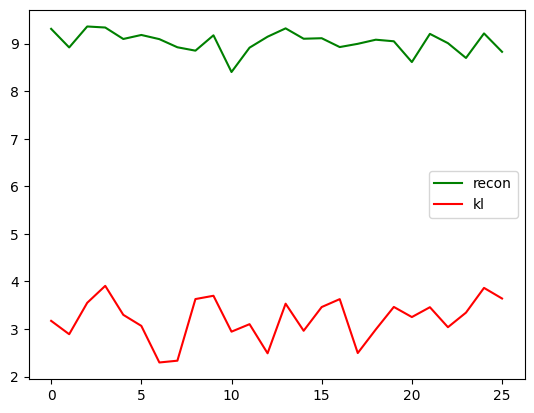

  1%|          | 26/2308 [00:07<11:32,  3.30it/s]


KeyboardInterrupt: 

In [22]:
train(net, train_loader, optimizer, 10)